##**Problem Statement:**

A US-based housing company named **Surprise Housing** has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.

The company wants to know:



*   Which variables are significant in predicting the price of a house, and
*   How well those variables describe the price of a house.




---


##**Business Goal:**

To build a model that can predict the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns.


In [ ]:
#importing the required libraries
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

In [ ]:
#installing the module category_encoders for encoding the categorical variable
!pip install category_encoders
from category_encoders import TargetEncoder

In [ ]:
#Loading the data using pandas

data = 'https://cdn.upgrad.com/UpGrad/temp/9cefd607-bbb7-443d-bb3e-eac9fef04453/train.csv'
house_df = pd.read_csv(data)
print("Shape of the given dataset is:",house_df.shape)

Shape of the given dataset is: (1460, 81)


In [ ]:
#Viewing the top 5 rows of the imported dataset
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#making a list of columns present in the original dataframe before starting the analysis
ColHouse_df = list(house_df.columns)

In [ ]:
#dropping the Id column
house_df.drop(labels='Id',axis=1, inplace=True)

In [ ]:
#viewing the information on the data types for the various attributes present in the dataframe
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [ ]:
#printing the number of categorical and continous variables in the original dataset post the removal of 'Id' attribute
print("Number of Categorical Variables present in the original dataframe:", len(house_df.select_dtypes(include='object').columns))
print("Number of Continous Variables present in the original dataframe:", len(house_df.select_dtypes(exclude='object').columns))

Number of Categorical Variables present in the original dataframe: 43
Number of Continous Variables present in the original dataframe: 37


In [ ]:
#checking the dataset for Duplicates
print("Number of Duplicated Rows:" , len(house_df[house_df.duplicated()]))

Number of Duplicated Rows: 0


In [ ]:
#checking if any row is only filled with Null's
print("Number of rows with all attributes as Null values:", house_df.isnull().all(axis=1).sum())

Number of rows with all attributes as Null values: 0


In [ ]:
#checking if any rows has more than 5 Null values
print("Number of rows with more than 5 Null values:",len(house_df[house_df.isnull().sum(axis=1)>5]))

Number of rows with more than 5 Null values: 174


Before dealing with the Null values, lets take a momoment to analyze the distribution of the target variable "SalePrice"


---


###SalePrice Distribution:

In [ ]:
#describe the target variable to gain sight on its distribution
house_df.SalePrice.describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,0.97,0.99])

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
97%      374230.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64

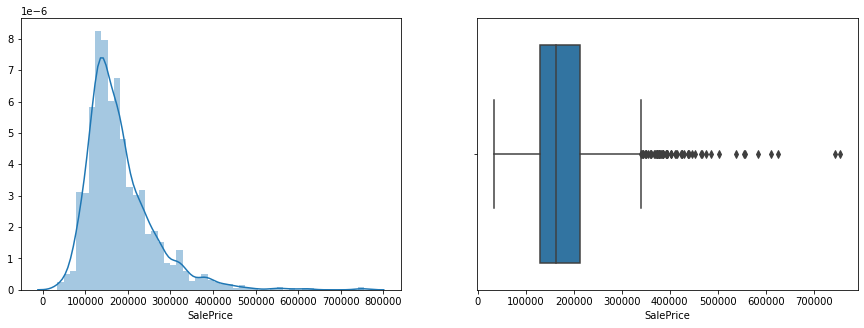

In [ ]:
#plotting a distplot and boxplot to analyze the distribution
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(house_df.SalePrice)

plt.subplot(1,2,2)
sns.boxplot(house_df.SalePrice)
plt.show()

In [ ]:
#Measureing the skewness of the plot
print("Skewness of SalePrice:",round(house_df.SalePrice.skew(),2))

Skewness of SalePrice: 1.88


From the above distplot we can see that the distribution is right skewed and not a normal distribution

One of the methodologies to deal with skewed data is performing a log transformation

In [ ]:
print("Skewness of SalePrice post the log transormation:", round(np.log(house_df.SalePrice).skew(),2))

Skewness of SalePrice post the log transormation: 0.12


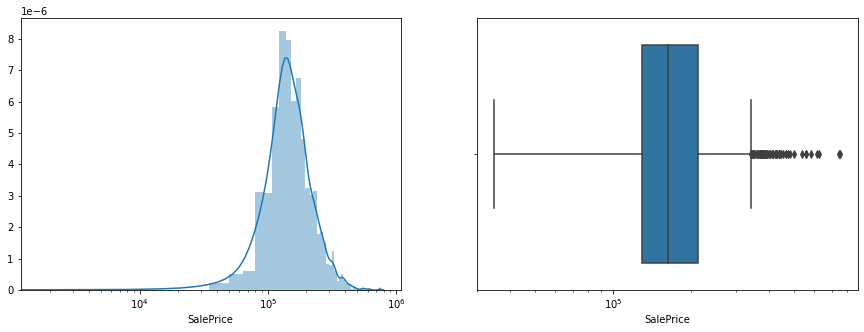

In [ ]:
#plotting a distplot and boxplot to analyze the log transformation
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(house_df.SalePrice)
plt.xscale('log')

plt.subplot(1,2,2)
sns.boxplot(house_df.SalePrice)
plt.xscale('log')
plt.show()

###Coming Back to the analyzing the Null values in the dataset

In [ ]:
#checking for percentage of nulls present in each attribute
nan_val = house_df.isnull().sum()/len(house_df.index)
nan_val[nan_val != 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

The Null values are as higher than 90% for 3 of the attributes ('Alley', 'PoolQC', MiscFeature'). But, before terminating all the listed fields as null, it would be appropriate to consider that the NaN values here represent the lack of the feature avaialbilty like No Alley or No Pool rather than representing missing data.

Therefore, imputing the coloumn would be a wise choice in making the most of the available dataset.

In [ ]:
#Imputing the appropriate missing fields as 'None'
col_list = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'GarageType','GarageFinish','GarageQual','GarageCond']
for col in col_list:
  house_df[col].fillna('None',inplace=True)

In [ ]:
# the object columns have been imputed with null
#let's analyze these parameters for the None %
print("The presence of the value None > 80% for each of the attributes are as listed")
for l in col_list:
  n = house_df[l].value_counts()/len(house_df[l])
  nv = list(map(lambda x: round(100*x,2),list(n.values)))
  ni = list(n.index)
  for i in range(len(nv)):
    if nv[i] > 80 and ni[i] =='None':
      print('{}: {}%'.format(l,nv[i]))

The presence of the value None > 80% for each of the attributes are as listed
Alley: 93.77%
PoolQC: 99.52%
Fence: 80.75%
MiscFeature: 96.3%


The above listed 4 attributes seems to have most of their data as None, before removing them, let's analyze the impact of these attributes on our target variable

Alley
Grvl    122219.080000
None    183452.131483
Pave    168000.585366
Name: SalePrice, dtype: float64


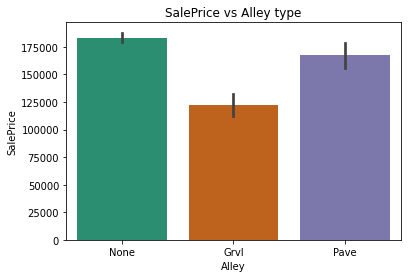

In [ ]:
#plotting and visualizing how SalePrice varies w.r.t different Alley types
print(house_df.groupby('Alley')['SalePrice'].mean())
sns.barplot(house_df.Alley, house_df.SalePrice,palette='Dark2')
plt.title('SalePrice vs Alley type')
plt.show()

PoolQC
Ex      490000.000000
Fa      215500.000000
Gd      201990.000000
None    180404.663455
Name: SalePrice, dtype: float64


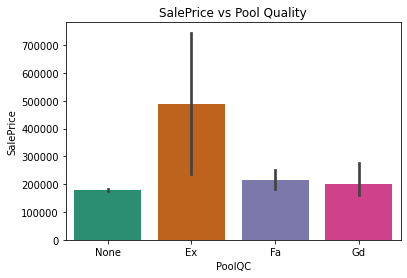

In [ ]:
#plotting and visualizing how SalePrice varies w.r.t different Pool Quality
print(house_df.groupby('PoolQC')['SalePrice'].mean())
sns.barplot(house_df.PoolQC, house_df.SalePrice,palette='Dark2')
plt.title('SalePrice vs Pool Quality')
plt.show()

Fence
GdPrv    178927.457627
GdWo     140379.314815
MnPrv    148751.089172
MnWw     134286.363636
None     187596.837998
Name: SalePrice, dtype: float64


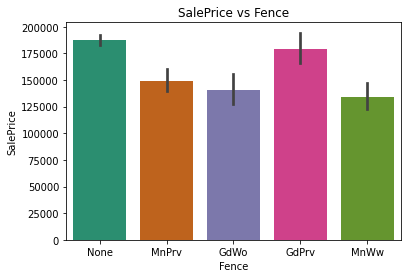

In [ ]:
#plotting and visualizing how SalePrice varies w.r.t different Fence Quality
print(house_df.groupby('Fence')['SalePrice'].mean())
sns.barplot(house_df.Fence, house_df.SalePrice,palette='Dark2')
plt.title('SalePrice vs Fence')
plt.show()

MiscFeature
Gar2    170750.000000
None    182046.410384
Othr     94000.000000
Shed    151187.612245
TenC    250000.000000
Name: SalePrice, dtype: float64


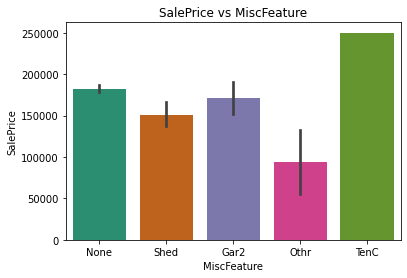

In [ ]:
#plotting and visualizing how SalePrice varies w.r.t different Misc Features
print(house_df.groupby(['MiscFeature'])['SalePrice'].mean())
sns.barplot(house_df.MiscFeature, house_df.SalePrice,palette='Dark2')
plt.title('SalePrice vs MiscFeature')
plt.show()

All show significant contribution majority contribution more than 180000; close to the avg SalePrice, hence these columns are retained

Moving on with other Null values

In [ ]:
#checking for the remaining nulls
nan_val = house_df.isnull().sum()/len(house_df.index)
nan_val[nan_val!=0]

LotFrontage    0.177397
MasVnrType     0.005479
MasVnrArea     0.005479
Electrical     0.000685
GarageYrBlt    0.055479
dtype: float64

In [ ]:
#filling the null values with the median value for LotFrontage
house_df.LotFrontage.fillna(house_df.LotFrontage.median(),inplace=True)

In [ ]:
#Replacing the null with mode value
house_df.MasVnrType.fillna(house_df.MasVnrType.mode()[0],inplace=True)

#replacing the null with median value
house_df.MasVnrArea.fillna(house_df.MasVnrArea.median(),inplace=True)

In [ ]:
#Replacing the null with mode value i.e. the most occuring value in the column Electrical
house_df.Electrical.fillna(house_df.Electrical.mode()[0],inplace=True)

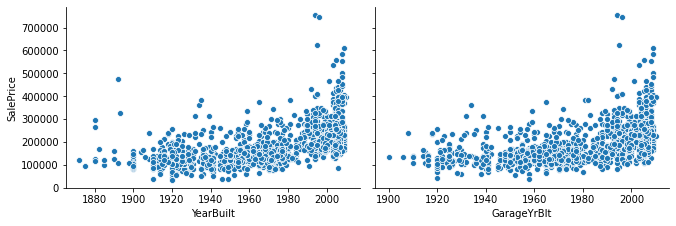

In [ ]:
#We are left with only the attribute GarageYrBlt to fill in the null values
#plotting the distribution for YearBuilt and GarageBuilt and how it affects the SalePrice
sns.pairplot(x_vars=['YearBuilt','GarageYrBlt'],y_vars='SalePrice',data=house_df,aspect=1.5,height=3)
plt.show()

Since Garage and House age follow almost same pattern, hence Garage year is dropped

In [ ]:
house_df.drop(labels=['GarageYrBlt'],axis=1,inplace=True)

In [ ]:
#checking for the remaining nulls
nan_val = house_df.isnull().sum()/len(house_df.index)
nan_val[nan_val!=0]

Series([], dtype: float64)

All the NaN values from the original datset are taken care of

###Outlier treatment

Extreme outliers that tend to deviate the attributes contribution towards the SalePrice predictions is deducted and removed

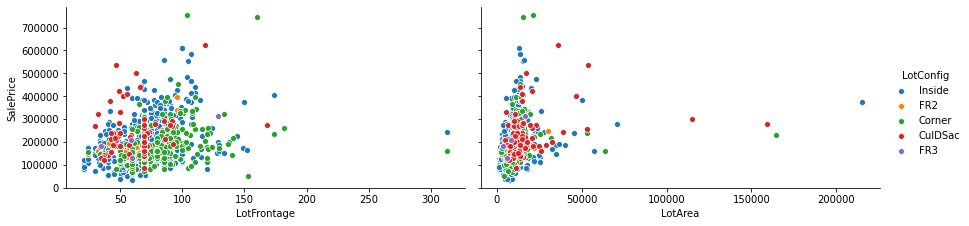

In [ ]:
#visualizing and analzing LotFrontage and LotArea
sns.pairplot(house_df,x_vars=['LotFrontage','LotArea'],y_vars='SalePrice',height=3,aspect=2,hue='LotConfig')
plt.show()

In [ ]:
#2 outlier points beyond the LotFrontage value 300 are removed
house_df = house_df[house_df.LotFrontage<300]
#4 outliers points beyond teh LotArea value 105000 are removed
house_df = house_df[house_df.LotArea<105000]

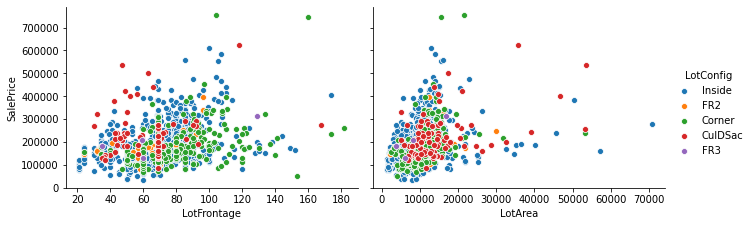

In [ ]:
#visualizing and analzing LotFrontage and LotArea
sns.pairplot(house_df,x_vars=['LotFrontage','LotArea'],y_vars='SalePrice',height=3,aspect=1.5,hue='LotConfig')
plt.show()

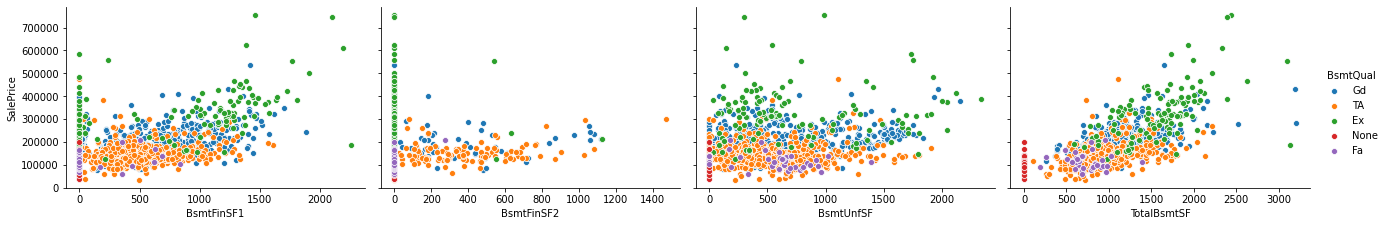

In [ ]:
#Visualzing Basement details
sns.pairplot(house_df,x_vars=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'],y_vars='SalePrice',height=3,aspect=1.5,hue='BsmtQual')
plt.show()

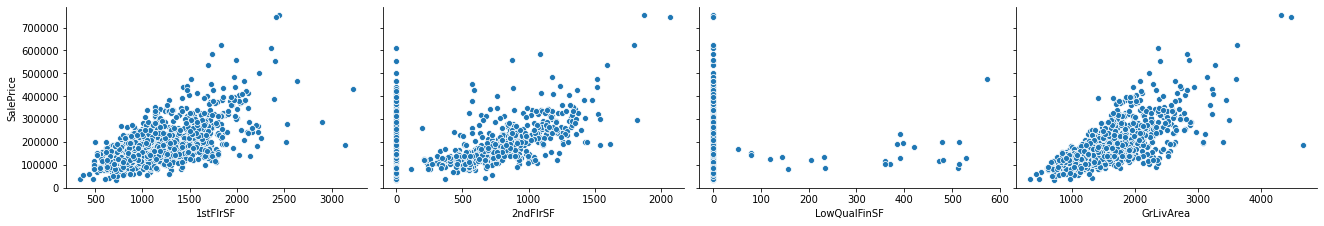

In [ ]:
#Visualzing Floor details
sns.pairplot(house_df,x_vars=['1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea'],y_vars='SalePrice',height=3,aspect=1.5)
plt.show()

From the above plots, we can conclude that the attribute,


*   TotalBsmtSF is the total of all the given Basement area i.e. BsmtFinSF1+BsmtFinSF2+BsmtUndSF
*   GrLivArea is the total of all the living area i.e 1stFlrSF+2stFlrSF+LowQualFinSF




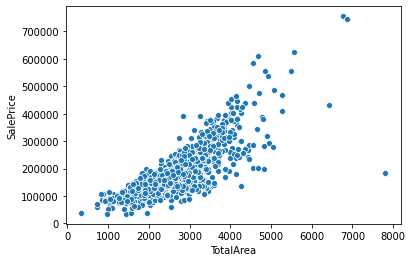

In [ ]:
#total area inclusing the basement
house_df['TotalArea'] = house_df['TotalBsmtSF'] + house_df['GrLivArea']
sns.scatterplot(house_df.TotalArea,house_df.SalePrice)
plt.show()

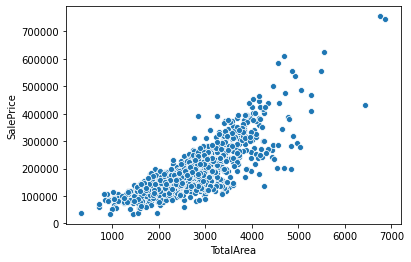

In [ ]:
#removing the outlier point where TotalArea > 7500
house_df = house_df[house_df.TotalArea < 7500]
sns.scatterplot(x='TotalArea', y='SalePrice', data=house_df)

In [ ]:
#dropping the variables
house_df.drop(labels=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea'],axis=1,inplace=True)

Moving on with the analysis of the remaining attributes

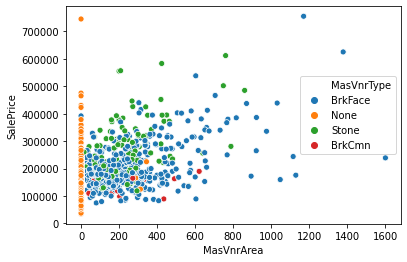

In [ ]:
#Analyzing MasVnrArea and MasVnrType
sns.scatterplot(x='MasVnrArea',y='SalePrice',data=house_df,hue='MasVnrType')
plt.show()

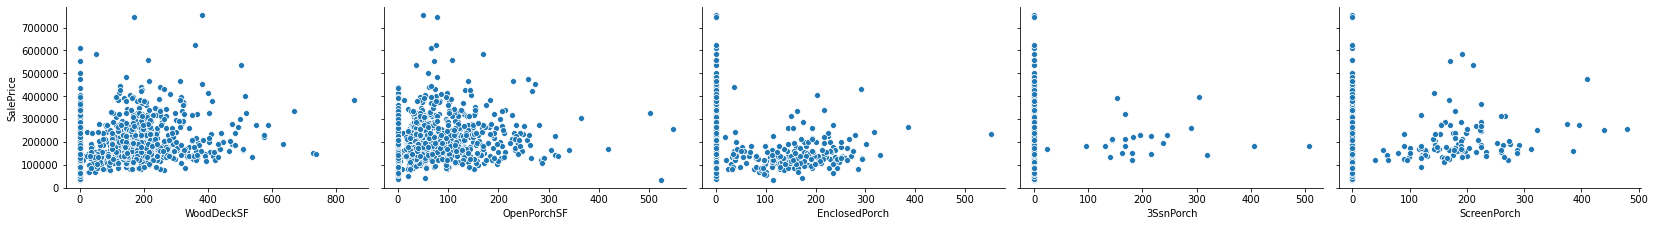

In [ ]:
#Visulaizing the Porch Areas
sns.pairplot(house_df,x_vars=['WoodDeckSF','OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch'],y_vars='SalePrice',height=3,aspect=1.5)
plt.show()

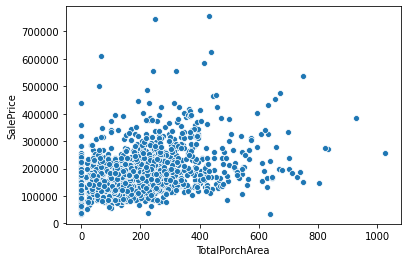

In [ ]:
#Combining all the PorchAreas
house_df['TotalPorchArea'] = house_df['WoodDeckSF'] + house_df['OpenPorchSF'] + house_df['EnclosedPorch'] + house_df['3SsnPorch'] + house_df['ScreenPorch']
sns.scatterplot(house_df.TotalPorchArea,house_df.SalePrice)

In [ ]:
#dropping the columns
house_df.drop(labels=['WoodDeckSF','OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch'],axis=1,inplace=True)

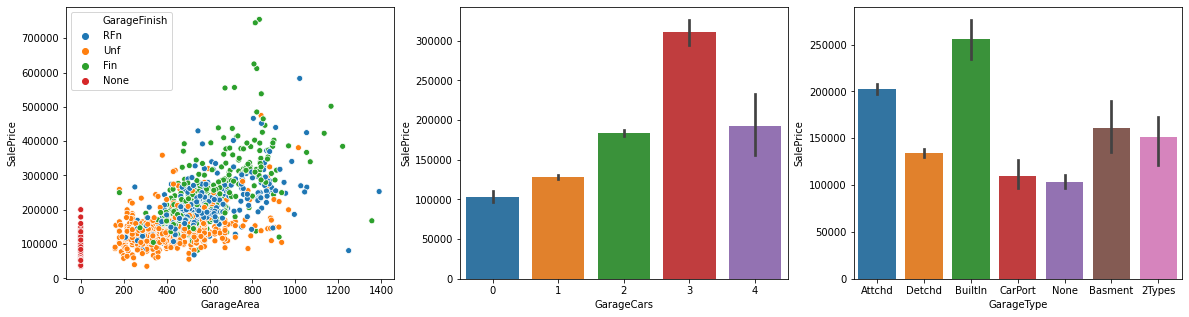

In [ ]:
#Visualizing Garage details
#sns.pairplot(house_df,x_vars=['GarageCars','GarageArea','GarageType'],y_vars='SalePrice',hue='GarageFinish',height=3,aspect=1.5)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(house_df.GarageArea,house_df.SalePrice,hue=house_df.GarageFinish)

plt.subplot(1,3,2)
sns.barplot(house_df.GarageCars,house_df.SalePrice)

plt.subplot(1,3,3)
sns.barplot(house_df.GarageType,house_df.SalePrice)
plt.show()

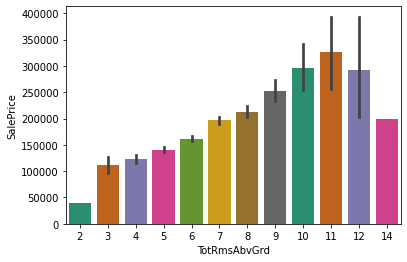

In [ ]:
#Visulaizing the total rooms vs SalePrice
sns.barplot(house_df.TotRmsAbvGrd,house_df.SalePrice,palette='Dark2')
plt.show()

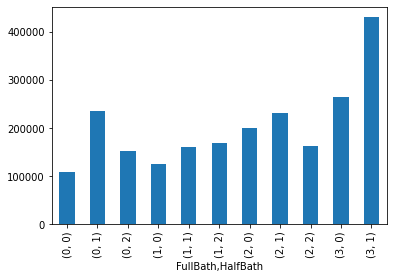

In [ ]:
#Visulazing Full and Half Baths
house_df.groupby(['FullBath','HalfBath'])['SalePrice'].mean().plot(kind='bar')

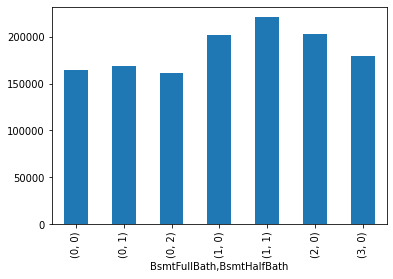

In [ ]:
#Visualizing Basement Full and Half Baths
house_df.groupby(['BsmtFullBath','BsmtHalfBath'])['SalePrice'].mean().plot(kind='bar')

In [ ]:
#combining all the number of bathrooms
house_df['TotalBathrooms'] = house_df['FullBath'] + house_df['HalfBath']/2 + house_df['BsmtFullBath'] + house_df['BsmtHalfBath']/2

In [ ]:
#dropping
house_df.drop(labels=['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'],axis=1,inplace=True)

###DataType Conversions

In [ ]:
#It can be noticed that attribute MSSubClass is of datatype int64, but as per the data dictonary provided, 
#this column Identifies the type of dwelling involved in the sale and hence needs to be converted to datatype object
house_df['MSSubClass'] = house_df['MSSubClass'].astype('str')

In [ ]:
#The attribute MoSold is also of data type int which can be converted to its corresponding string value
house_df['MonthSold'] = pd.to_datetime(house_df['MoSold'],format='%m').dt.month_name().str.slice(stop=3)
house_df[['MonthSold','MoSold']].head()

,MonthSold,MoSold
0,Feb,2
1,May,5
2,Sep,9
3,Feb,2
4,Dec,12


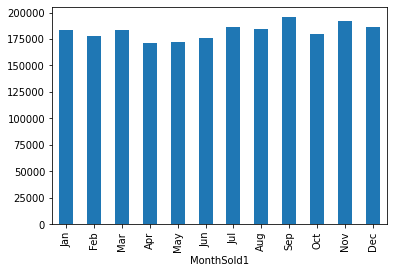

In [ ]:
#creating a variable only for plotting purposes.
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
house_df['MonthSold1'] = pd.Categorical(house_df['MonthSold'], categories=months, ordered=True)
#plotting the SalePrice throughout the months
house_df.groupby('MonthSold1')['SalePrice'].mean().plot(kind='bar')
plt.show()

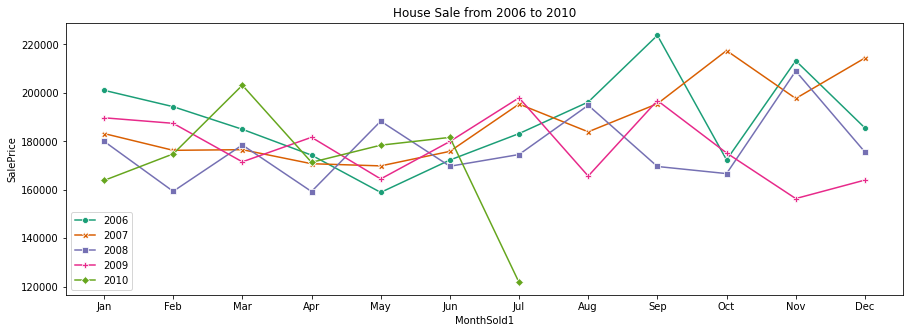

In [ ]:
#SaleYear vs months
plt.figure(figsize=(15,5))
sns.lineplot(house_df.MonthSold1,house_df.SalePrice,hue=house_df.YrSold,markers=True,ci=None,palette='Dark2',dashes=False,
             style=house_df.YrSold.astype(str),legend=False)
plt.title("House Sale from 2006 to 2010")
plt.legend(np.arange(2006,2011))
plt.show()

House Sales seems to be in its peak during September of 2006 and in its lowest point during July of 2010




In [ ]:
#dropping off the attribute MoSold
house_df.drop(['MoSold','MonthSold1'],axis=1,inplace=True)

In [ ]:
#The attributes YearBuilt and YearRemodAdd can be used to obtain the age of the house from the time it was constructed or remodelled to the year the house was sold
house_df['HouseAge'] = house_df.YrSold - house_df.YearBuilt
house_df['RemodelAge'] = house_df.YrSold - house_df.YearRemodAdd

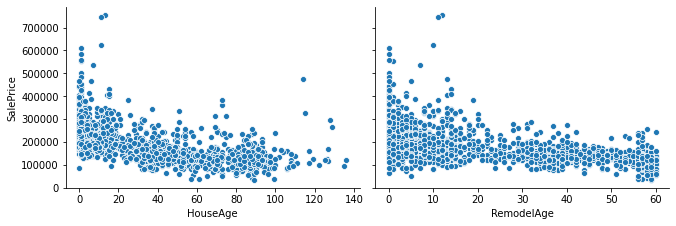

In [ ]:
#plotting the values
sns.pairplot(house_df,x_vars=['HouseAge','RemodelAge'],y_vars='SalePrice',aspect=1.5,height=3)
plt.show()

It can be observed that the SalePrice of the houses is more if for the recently bulit or remodelled in contrast to the old built or remodelled houses

In [ ]:
#dropping the columns
house_df.drop(labels=['YearBuilt','YearRemodAdd'],axis=1,inplace=True)

#converting the Year Sold attribute to string
house_df['YrSold'] = house_df.YrSold.astype('str')

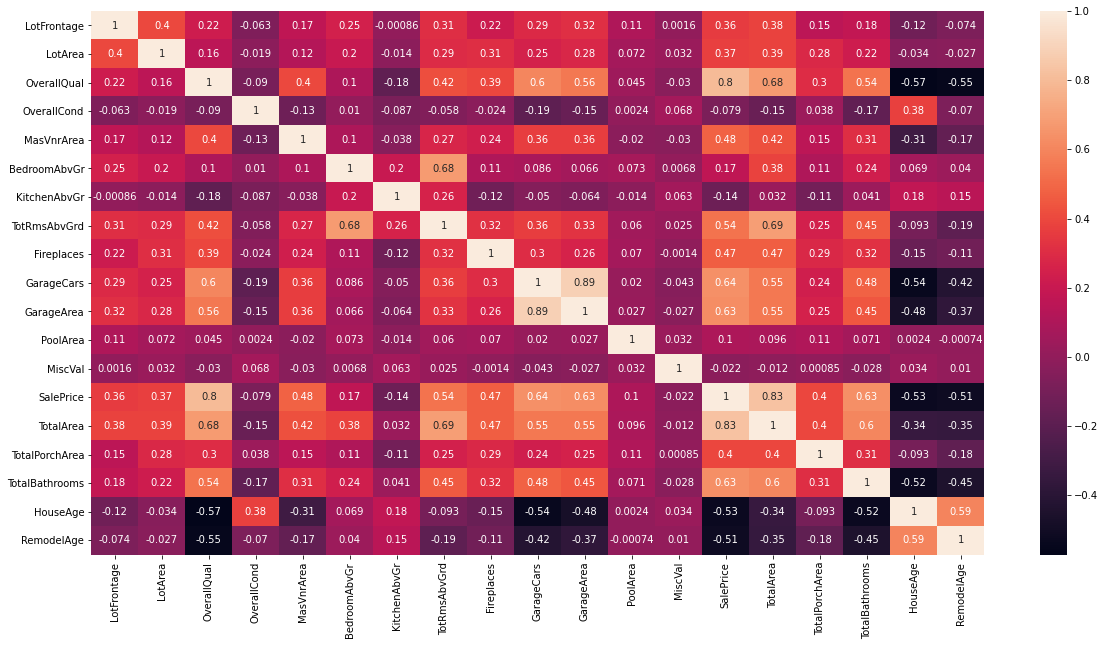

In [ ]:
#Plotting a heat map for the continous variables
corr = house_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True)
plt.show()

In [ ]:
#Finding highly corelated attributes
c = (corr.mask(np.eye(len(corr),dtype=bool)).abs()> 0.85).any()
c.index[c.values==True]

Index(['GarageCars', 'GarageArea'], dtype='object')

In [ ]:
#Since GarageArea contributes 5% more than GarageArea in predicting SalePrice, GarageArea is dropped
house_df.drop('GarageArea',axis=1,inplace=True)

###Categorical Feature Analysis

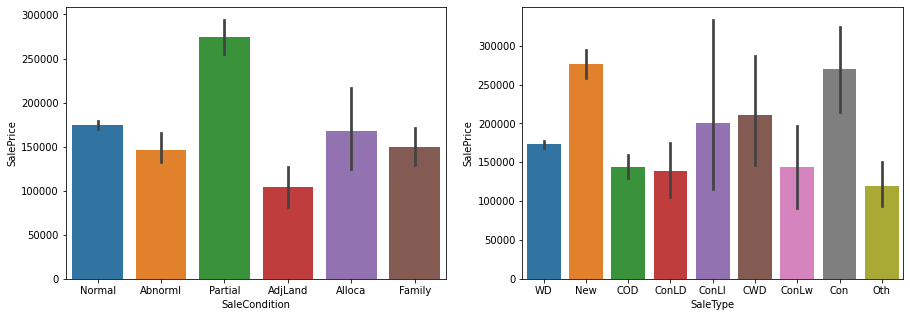

In [ ]:
#Visualizing SaleCondition and SaleType
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(house_df.SaleCondition,house_df.SalePrice)

plt.subplot(1,2,2)
sns.barplot(house_df.SaleType,house_df.SalePrice)
plt.show()

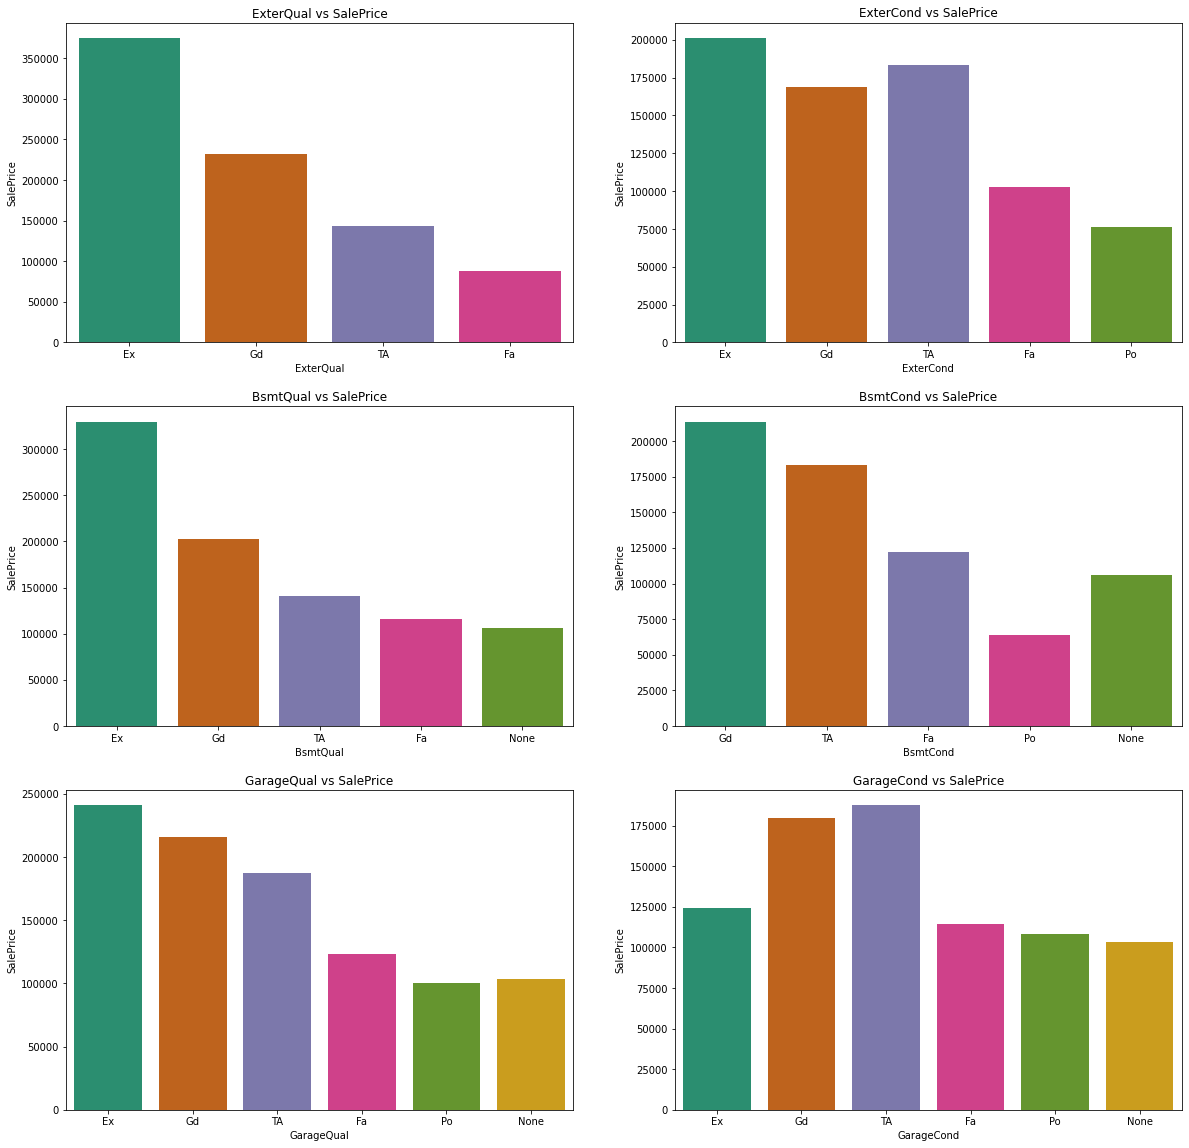

In [ ]:
#Visualizing Quality vs Condition for various attributes
con_list = ['ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond']

def order(x):
  order_list =['Ex','Gd','TA','Fa','Po','None']
  x1 = list(house_df[x].unique())
  return([i for j in order_list for i in x1 if j==i])

fig = plt.figure(figsize=(20,20))
for i,col in enumerate(con_list):
  ax = fig.add_subplot(3,2,i+1)
  sns.barplot(house_df[col],house_df['SalePrice'],order=order(col),ax=ax,ci=None,palette='Dark2')
  ax.set_title(col+' vs SalePrice')


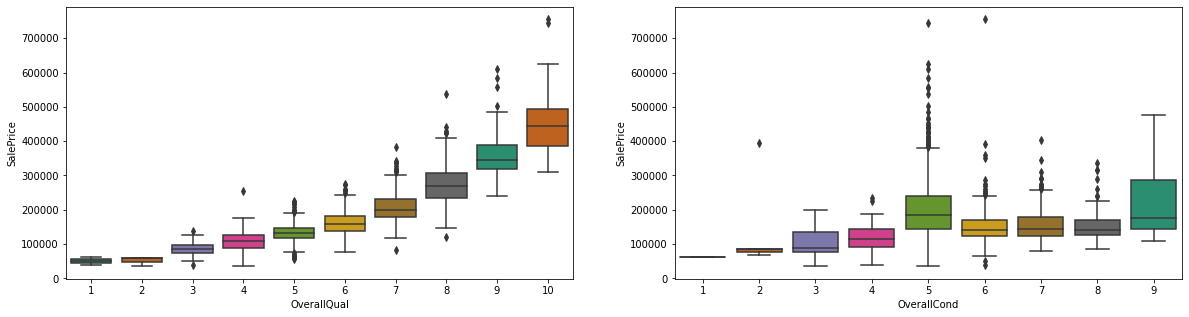

In [ ]:
#Visualizing the overall quality and condition ratings
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(x='OverallQual',y='SalePrice',data=house_df,palette='Dark2')

plt.subplot(1,2,2)
sns.boxplot(x='OverallCond',y='SalePrice',data=house_df,palette='Dark2')
plt.show()



*   OverallQual seems to be proportional to the rating i.e. higher the rating, higher the SalePrice
*   OverallCond, above at rating 5 the saleprice seem to be high

In [ ]:
#converting the overall cond to obj
house_df['OverallCond'] = house_df.OverallCond.astype('str')

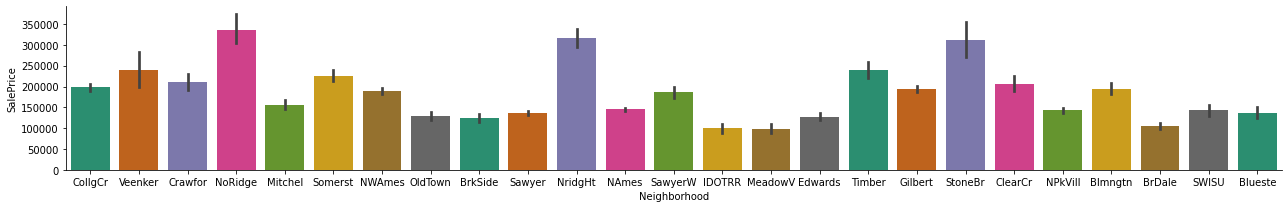

In [ ]:
#Visualizing the Neighborhood
sns.catplot(x='Neighborhood',y='SalePrice',data=house_df,height=3,aspect=6,kind='bar',palette='Dark2')
plt.show()

In [ ]:
#determining top5 neighborhood
neigh = house_df.groupby(['Neighborhood'])['SalePrice'].mean().to_frame('price').reset_index()
neigh['price_in_thousands'] = neigh['price']/1e3
print('Top 5 Highest Selling Neighborhood:')
display(neigh[['Neighborhood','price_in_thousands']].sort_values(by='price_in_thousands',ascending=False).head())

Top 5 Highest Selling Neighborhood:


,Neighborhood,price_in_thousands
15,NoRidge,335.295317
16,NridgHt,316.270623
22,StoneBr,310.499000
23,Timber,238.929250
24,Veenker,238.772727


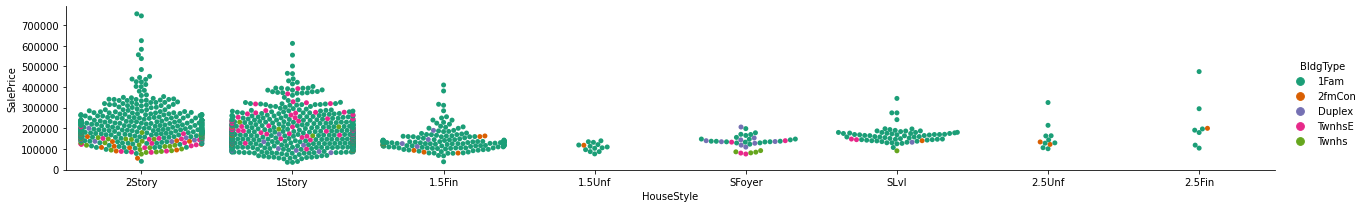

In [ ]:
#Visualizing the HouseStyle and Building type w.r.t SalePrice
sns.catplot(x='HouseStyle',y='SalePrice',data=house_df,hue='BldgType',height=3,aspect=6,kind='swarm',palette='Dark2')
plt.show()

2Story and 1Story seems to be the most populat Sale choices

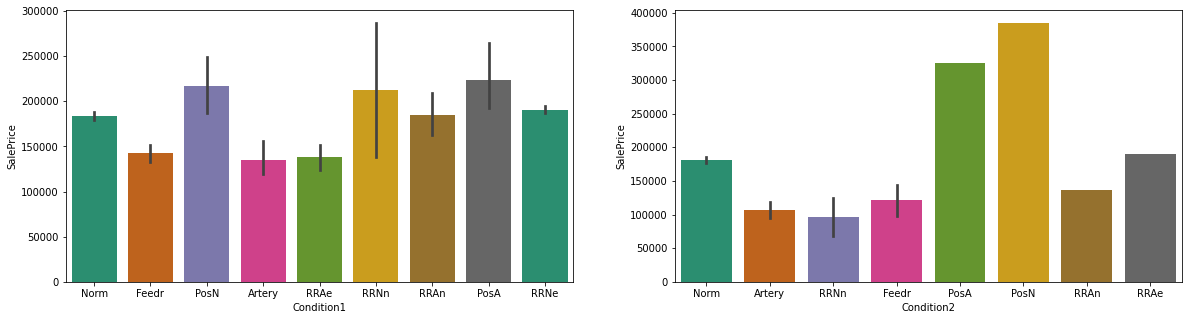

In [ ]:
#Visualizing the Condition1 and Condition2
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.barplot(x='Condition1',y='SalePrice',data=house_df,palette='Dark2')

plt.subplot(1,2,2)
sns.barplot(x='Condition2',y='SalePrice',data=house_df,palette='Dark2')
plt.show()

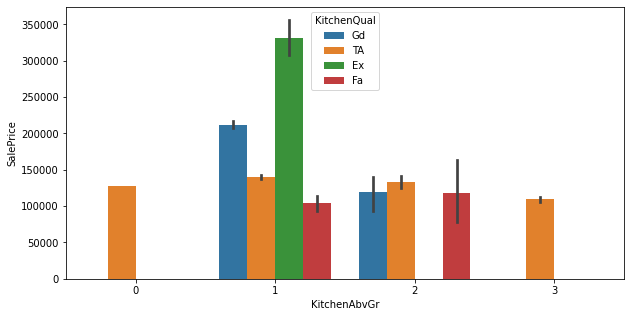

Number of Kitches and their avg SalePrice:
KitchenAbvGr  KitchenQual
0             TA             127500.000000
1             Ex             331742.010204
              Fa             103677.735294
              Gd             212275.844828
              TA             140195.759287
2             Fa             118400.000000
              Gd             119666.666667
              TA             132811.403509
3             TA             109500.000000
Name: SalePrice, dtype: float64


In [ ]:
#Visualizing the Kitchen attributes
plt.figure(figsize=(10,5))
sns.barplot(x='KitchenAbvGr',y='SalePrice',data=house_df,hue='KitchenQual')
plt.show()
print('Number of Kitches and their avg SalePrice:')
print(house_df.groupby(['KitchenAbvGr','KitchenQual'])['SalePrice'].mean())

On an average, 1 Kitchen Houses tend to sell more

Kitchen Quality, when present tend range from Fair to Excellent

###Mapping the categorical variables

In [ ]:
#listing the categorical features
house_df.select_dtypes(include='object').columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'YrSold', 'SaleType', 'SaleCondition',
       'MonthSold'],
      dtype='object')

In [ ]:
#Mapping the scale of various Qualities and Conditions for the respective attributes
map_dict = {'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0}
col1_list = ['ExterQual','BsmtQual','GarageQual','GarageCond','ExterCond','BsmtCond','KitchenQual','PoolQC','FireplaceQu','HeatingQC']
for col in col1_list:
  house_df[col] = house_df[col].map(map_dict)

In [ ]:
#checking if any 2 unique values cols can be mapped
obj_list = list(house_df.select_dtypes(include='object'))
n = house_df[obj_list].nunique()
n[n==2]

Street        2
Utilities     2
CentralAir    2
dtype: int64

In [ ]:
#Mapping the distinct Street values
house_df.Street.value_counts()
house_df['Street'] = house_df['Street'].map({'Pave':1,'Grvl':0})
house_df.Street.value_counts()

1    1448
0       5
Name: Street, dtype: int64

In [ ]:
#Mapping the distinct Utilities values
house_df.Utilities.value_counts()
house_df['Utilities'] = house_df['Utilities'].map({'AllPub':1,'NoSeWa':0})
house_df.Utilities.value_counts()

1    1452
0       1
Name: Utilities, dtype: int64

In [ ]:
#Mapping the distinct CentralAir values
house_df.CentralAir.value_counts()
house_df['CentralAir'] = house_df['CentralAir'].map({'Y':1,'N':0})
house_df.CentralAir.value_counts()

1    1358
0      95
Name: CentralAir, dtype: int64

In [ ]:
#Listing out the distribution for the attribute, ELectrical
house_df.Electrical.value_counts()/len(house_df.Electrical)

SBrkr    0.913971
FuseA    0.064694
FuseF    0.018582
FuseP    0.002065
Mix      0.000688
Name: Electrical, dtype: float64

In [ ]:
#Deriving a new feature from Electrical
#since 91% belongs to SBrkr, we will clasiify electrical as 2 groups, SBrkr and others
house_df['Electrical'] = house_df['Electrical'].map(lambda x: x if x=='SBrkr' else 'Others')
house_df.Electrical.value_counts()

SBrkr     1328
Others     125
Name: Electrical, dtype: int64

In [ ]:
#Grouping the type of Heating w.r.t the SalePrice
house_df.groupby('Heating')['SalePrice'].mean()

Heating
Floor     72500.000000
GasA     181808.415612
GasW     154375.235294
Grav      75271.428571
OthW     125750.000000
Wall      92100.000000
Name: SalePrice, dtype: float64

In [ ]:
#deriving a new feature from the existing values in the Heating column
house_df.Heating.value_counts()
house_df['Heating'] = house_df['Heating'].map(lambda x: x if x in ('GasA','GasW','OthW') else 'Others')
house_df.Heating.value_counts()

GasA      1422
GasW        17
Others      12
OthW         2
Name: Heating, dtype: int64

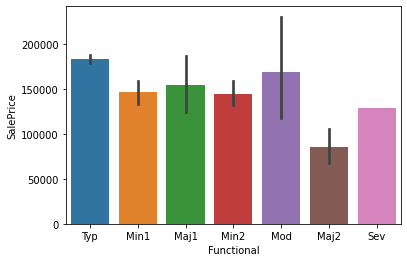

In [ ]:
#Visualizing how the various types of home functionality varies w.r.t the SalePrice
sns.barplot(house_df.Functional,house_df.SalePrice)
plt.show()

In [ ]:
#Assuming the deductions are typical < min < mod < maj < sev
#Mapping the same to encode the data values present in the column, Functional
house_df.Functional.value_counts()
house_df['Functional'] = house_df['Functional'].map({'Typ':0, 'Min1':1, 'Min2':1, 'Mod':2, 'Maj1':3, 'Maj2':3, 'Sev':4})
house_df.Functional.value_counts()

0    1353
1      65
3      19
2      15
4       1
Name: Functional, dtype: int64

In [ ]:
#making a copy of the modified dataframe
house_df1 = house_df.copy()

###Summary on the EDA performed:

In [ ]:
#1460 corresponds to the row size of the original dataframe imported
print('Loss of Data from outlier elimination: {:.2%}'.format(1-house_df.shape[0]/1460))

Loss of Data from outlier elimination: 0.48%


In [ ]:
col_list1 = list(set(ColHouse_df)-set(house_df.columns))
print('The number of columns eliminated from the original dataset is:',len(col_list1))
print('The columns eliminated from the original dataset are:\n',col_list1)

The number of columns eliminated from the original dataset is: 23
The columns eliminated from the original dataset are:
 ['WoodDeckSF', '3SsnPorch', '1stFlrSF', 'BsmtFullBath', 'YearRemodAdd', 'GarageArea', 'GrLivArea', 'BsmtFinSF2', 'MoSold', 'LowQualFinSF', 'Id', 'BsmtFinSF1', '2ndFlrSF', 'BsmtUnfSF', 'YearBuilt', 'EnclosedPorch', 'ScreenPorch', 'GarageYrBlt', 'FullBath', 'OpenPorchSF', 'HalfBath', 'TotalBsmtSF', 'BsmtHalfBath']


In [ ]:
col_list2 = list(set(house_df.columns)-set(ColHouse_df))
print('The number of columns added post the EDA performed:',len(col_list2))
print('The columns added post the EDA are:\n',col_list2)

The number of columns added post the EDA performed: 6
The columns added post the EDA are:
 ['MonthSold', 'HouseAge', 'TotalArea', 'TotalBathrooms', 'RemodelAge', 'TotalPorchArea']


###Splitting the data into train and test set

In [ ]:
train, test = train_test_split(house_df,test_size=0.25,random_state=1)

In [ ]:
print("Train shape:",train.shape)
print("Test shape:", test.shape)

Train shape: (1089, 64)
Test shape: (364, 64)


###Scaling

In [ ]:
#Viewing the first 5 rows in the X_train
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice,TotalArea,TotalPorchArea,TotalBathrooms,MonthSold,HouseAge,RemodelAge
353,30,RM,60.0,8520,1,None,Reg,Lvl,1,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,6,8,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,BrkTil,3,3,No,Unf,Unf,GasA,4,1,SBrkr,2,1,3,5,0,0,0,Detchd,Unf,2,3,3,Y,0,0,None,None,0,2010,WD,Normal,105900,1344,106,1.0,May,82,7
1373,20,RL,69.0,11400,1,None,Reg,Lvl,1,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,10,5,Hip,CompShg,VinylSd,VinylSd,BrkFace,705.0,5,3,PConc,5,3,Gd,GLQ,Unf,GasA,5,1,SBrkr,2,1,5,8,0,2,4,Attchd,RFn,3,3,3,Y,0,0,None,None,0,2007,WD,Normal,466500,5266,454,3.5,Mar,6,5
701,20,RL,80.0,9600,1,None,Reg,Lvl,1,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,7,5,Hip,CompShg,HdBoard,HdBoard,BrkFace,168.0,3,3,CBlock,3,3,No,Unf,Unf,GasA,3,1,SBrkr,3,1,3,6,0,0,0,Attchd,Unf,2,3,3,Y,0,0,None,None,0,2006,COD,Normal,140000,2328,0,1.5,Jul,37,37
202,50,RL,50.0,7000,1,None,Reg,Lvl,1,Corner,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,6,6,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,4,BrkTil,2,3,No,LwQ,Unf,GasA,4,1,SBrkr,2,1,3,6,1,0,0,Attchd,Unf,1,3,3,Y,0,0,None,None,0,2006,COD,Normal,112000,1927,126,2.0,May,82,56
961,60,RL,69.0,12227,1,None,IR1,Lvl,1,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,6,7,Gable,CompShg,HdBoard,HdBoard,BrkFace,424.0,3,4,CBlock,4,4,No,ALQ,Unf,GasA,3,1,SBrkr,4,1,3,11,0,1,3,Attchd,Fin,2,3,3,Y,0,0,None,None,0,2008,WD,Normal,272000,4202,832,3.5,Jul,31,13


In [ ]:
#TargetEncoding the categorical features
ob_vals = list(train.select_dtypes(include='object').columns)

#fitting and transforming the categorical features
en1 = TargetEncoder(cols=ob_vals)
train[ob_vals] = en1.fit_transform(train[ob_vals],train['SalePrice'])
train[ob_vals].head()

,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,Electrical,GarageType,GarageFinish,PavedDrive,Fence,MiscFeature,YrSold,SaleType,SaleCondition,MonthSold
353,96007.862745,126391.940120,183418.371345,162680.556701,180884.978528,176377.821066,180252.585673,128054.227848,184636.394681,181350.946296,186268.702882,175053.683521,156274.074074,171194.281106,179933.448372,213625.479798,213956.087855,157714.106977,130179.177570,166153.911142,173132.212963,185244.369775,182349.575985,187137.161484,132516.182456,141134.389640,186476.281,187458.071591,182199.978137,179649.374046,173225.903499,174450.531632,173923.866667
1373,184574.611399,191456.824419,183418.371345,162680.556701,180884.978528,176377.821066,180252.585673,334370.266667,184636.394681,181350.946296,186268.702882,175053.683521,203646.638126,224355.262626,179933.448372,213625.479798,213956.087855,202260.945946,226897.585216,257941.744898,234310.511254,185244.369775,182349.575985,187137.161484,201761.488408,199640.243976,186476.281,187458.071591,182199.978137,186723.573705,173225.903499,174450.531632,183972.683544
701,184574.611399,191456.824419,183418.371345,162680.556701,180884.978528,176377.821066,180252.585673,191311.562500,184636.394681,181350.946296,186268.702882,175053.683521,203646.638126,224355.262626,179933.448372,164820.847059,169614.064103,202260.945946,148275.008511,166153.911142,173132.212963,185244.369775,182349.575985,187137.161484,201761.488408,141134.389640,186476.281,187458.071591,182199.978137,179821.018018,149717.187500,174450.531632,185463.279330
202,145590.589286,191456.824419,183418.371345,162680.556701,180884.978528,184517.919598,180252.585673,128054.227848,130792.105263,181350.946296,186268.702882,145030.638655,153256.765027,171194.281106,179933.448372,145641.212644,145991.494048,157714.106977,130179.177570,166153.911142,140524.000000,185244.369775,182349.575985,187137.161484,201761.488408,141134.389640,186476.281,187458.071591,182199.978137,179821.018018,149717.187500,174450.531632,173923.866667
961,240124.605150,191456.824419,183418.371345,209371.402667,180884.978528,184517.919598,180252.585673,191311.562500,218433.302298,181350.946296,186268.702882,212525.785075,156891.447368,171194.281106,179933.448372,164820.847059,169614.064103,202260.945946,148275.008511,166153.911142,163589.329268,185244.369775,182349.575985,187137.161484,201761.488408,242945.902724,186476.281,187458.071591,182199.978137,178261.252174,173225.903499,174450.531632,185463.279330


In [ ]:
#splitting the X and y train datasets
X_train = train.drop('SalePrice',axis=1)
y_train = train[['SalePrice']]

In [ ]:
#Transforming y_train using log transformation
y_train = np.log(y_train)

#viewing the first 5 values:
y_train[:5]

,SalePrice
353,11.570251
1373,13.053013
701,11.849398
202,11.626254
961,12.513557


In [ ]:
#Scaling all the numerical features from the train set using the StandardScaler avaialble in sklearn libraray
scaler = StandardScaler()
cols = list(X_train.columns)
X_train[cols] = scaler.fit_transform(X_train[cols])

#viewing the first 5 rows post scaling:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,TotalArea,TotalPorchArea,TotalBathrooms,MonthSold,HouseAge,RemodelAge
353,-2.128538,-2.068730,-0.461489,-0.264394,0.060718,0.210526,-0.757816,-0.019388,0.030317,-0.403134,-0.165672,-0.907459,0.237673,0.068101,0.336089,-0.245206,-0.076506,-0.866283,-0.479425,-0.078749,1.017126,1.047129,-0.686686,-0.574381,-0.709024,2.605802,-1.218906,-0.558569,0.113962,-0.488515,-0.220389,0.274047,0.120767,-0.164015,0.258072,0.303771,-1.077920,-0.228416,-0.780608,-0.946279,-0.239989,-0.953690,-1.007697,-1.216961,-0.902723,0.312832,0.258488,0.264439,0.296504,-0.067337,-0.065493,0.436814,0.184662,-0.079137,-0.465502,-0.260293,-0.223353,-1.567057,-0.486606,-1.559487,-1.318117,1.544008,-0.760623
1373,0.085802,0.391105,-0.016219,0.262191,0.060718,0.210526,-0.757816,-0.019388,0.030317,-0.403134,-0.165672,2.619816,0.237673,0.068101,0.336089,-0.245206,2.872691,0.783800,2.093074,-0.078749,1.017126,1.047129,0.620787,3.430760,2.808641,-0.246176,1.095165,1.723913,0.113962,2.509550,1.469655,0.274047,0.120767,0.880504,0.258072,0.303771,-1.077920,-0.228416,2.244596,0.898288,-0.239989,2.174529,1.188166,0.517104,0.418443,1.670101,0.258488,0.264439,0.296504,-0.067337,-0.065493,0.436814,0.184662,-0.079137,1.788855,-0.260293,-0.223353,3.480813,1.726191,1.643608,0.525056,-1.000612,-0.857780
701,0.085802,0.391105,0.528000,-0.066924,0.060718,0.210526,-0.757816,-0.019388,0.030317,-0.403134,-0.165672,0.174018,0.237673,0.068101,0.336089,-0.245206,0.660793,0.783800,2.093074,-0.078749,-0.512996,-0.362304,0.620787,0.380036,-0.709024,-0.246176,-0.785948,-0.558569,0.113962,-0.488515,-0.220389,0.274047,0.120767,-1.208534,0.258072,0.303771,0.157717,-0.228416,-0.780608,-0.331424,-0.239989,-0.953690,-1.007697,0.517104,-0.902723,0.312832,0.258488,0.264439,0.296504,-0.067337,-0.065493,0.436814,0.184662,-0.079137,-0.410804,-1.037452,-0.223353,-0.300585,-1.160619,-0.918868,0.798464,0.037325,0.696743
202,-0.888874,0.391105,-0.956233,-0.542313,0.060718,0.210526,-0.757816,-0.019388,0.030317,0.296133,-0.165672,-0.907459,-3.364626,0.068101,0.336089,-1.461337,-0.076506,-0.971382,-0.479425,-0.078749,-1.114316,-1.113159,-0.686686,-0.574381,-0.709024,2.605802,-1.218906,-1.699810,0.113962,-0.488515,-1.121188,0.274047,0.120767,-0.164015,0.258072,0.303771,-1.077920,-0.228416,-0.780608,-0.331424,2.032601,-0.953690,-1.007697,0.517104,-0.902723,-1.044436,0.258488,0.264439,0.296504,-0.067337,-0.065493,0.436814,0.184662,-0.079137,-0.410804,-1.037452,-0.223353,-0.816698,-0.359434,-0.278249,-1.318117,1.544008,1.619741
961,1.474658,0.391105,-0.016219,0.413401,0.060718,0.210526,1.162167,-0.019388,0.030317,0.296133,-0.165672,0.174018,2.498760,0.068101,0.336089,1.272661,-0.076506,-0.844779,-0.479425,-0.078749,-0.512996,-0.362304,0.620787,1.834385,-0.709024,2.605802,-0.785948,0.582672,1.912579,-0.488515,-0.484010,0.274047,0.120767,-1.208534,0.258072,0.303771,1.393353,-0.228416,-0.780608,2.742854,-0.239989,0.610419,0.639200,0.517104,1.396361,0.312832,0.258488,0.264439,0.296504,-0.067337,-0.065493,0.436814,0.184662,-0.079137,-0.907860,-0.260293,-0.223353,2.111375,4.129745,1.643608,0.798464,-0.163566,-0.469150


###Modelling

In [ ]:
#Training a Linear Regression Model to make use of RFE to select the top 50 features
np.random.seed(1)
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#selecting top 50 features with RFE
rfe = RFE(lr,50,step=1)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=50, step=1, verbose=0)

In [ ]:
#Listing the columns that are selected by taraining and fitting the RFE model
rfe_col1 = list(X_train.columns[rfe.support_])
X_train = X_train[rfe_col1]
print("Shape of X_train:",X_train.shape)
print("Top 50 columns are:\n",X_train.columns)

Shape of X_train: (1089, 50)
Top 50 columns are:
 Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'Heating', 'HeatingQC', 'CentralAir', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolArea', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition', 'TotalArea',
       'TotalPorchArea', 'TotalBathrooms', 'MonthSold', 'HouseAge',
       'RemodelAge'],
      dtype='object')


Ridge Regression

In [ ]:
#Building a GridSerach model and finding the optimum alpha value

#Defining the KFolds
f1 = KFold(n_splits=5,shuffle=True,random_state=1)

#Defining the alphas
p1 = {'alpha': [0.01,0.1,0.5,1.0,1.5,5.0,10.0,20.0]}

#GirdSerach and Ridge Model
model2 = Ridge()
model2_cv = GridSearchCV(estimator=model2, param_grid=p1, scoring='neg_mean_absolute_error',
                         cv =f1,return_train_score=True,verbose=1,n_jobs=-1)

model2_cv.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.8s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 1.5, 5.0, 10.0, 20.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
#viewing the results in a dataframe
cv_results = pd.DataFrame(model2_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006299,0.000440,0.002396,0.000158,0.01,{'alpha': 0.01},-0.083871,-0.092807,-0.081234,-0.088679,-0.095086,-0.088335,0.005216,8,-0.083346,-0.080942,-0.082902,-0.081633,-0.079997,-0.081764,0.001234
1,0.005918,0.000332,0.002287,0.000056,0.1,{'alpha': 0.1},-0.083869,-0.092805,-0.081229,-0.088667,-0.095081,-0.088330,0.005216,7,-0.083345,-0.080941,-0.082901,-0.081631,-0.079996,-0.081763,0.001234
2,0.006029,0.000212,0.002518,0.000263,0.5,{'alpha': 0.5},-0.083864,-0.092796,-0.081207,-0.088616,-0.095055,-0.088308,0.005214,6,-0.083338,-0.080937,-0.082897,-0.081621,-0.079994,-0.081757,0.001233
3,0.006263,0.001075,0.003593,0.002385,1,{'alpha': 1.0},-0.083858,-0.092786,-0.081179,-0.088554,-0.095024,-0.088280,0.005212,5,-0.083330,-0.080933,-0.082892,-0.081609,-0.079992,-0.081751,0.001231
4,0.005609,0.000293,0.002255,0.000130,1.5,{'alpha': 1.5},-0.083853,-0.092775,-0.081152,-0.088493,-0.094993,-0.088253,0.005210,4,-0.083322,-0.080928,-0.082888,-0.081597,-0.079990,-0.081745,0.001230
5,0.007493,0.002186,0.002746,0.000236,5,{'alpha': 5.0},-0.083819,-0.092729,-0.080971,-0.088105,-0.094795,-0.088084,0.005204,3,-0.083269,-0.080903,-0.082869,-0.081546,-0.079987,-0.081715,0.001218
6,0.006088,0.000332,0.002443,0.000338,10,{'alpha': 10.0},-0.083787,-0.092697,-0.080732,-0.087647,-0.094571,-0.087887,0.005213,2,-0.083207,-0.080879,-0.082855,-0.081510,-0.079996,-0.081690,0.001201
7,0.005623,0.000514,0.002157,0.000317,20,{'alpha': 20.0},-0.083728,-0.092753,-0.080372,-0.086988,-0.094230,-0.087614,0.005256,1,-0.083127,-0.080841,-0.082876,-0.081532,-0.080040,-0.081683,0.001178


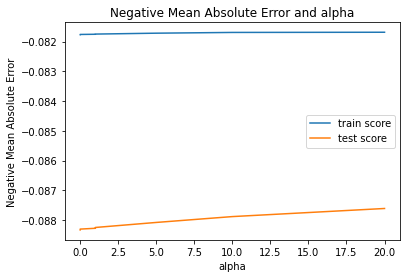

In [ ]:
# plotting the train and test mean score with the alpha values
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'])
plt.show()

In [ ]:
#Building a Ridge Regression model for the choosen alpha value
model_ridge = Ridge(alpha=5,random_state=1)
model_ridge.fit(X_train,y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=1, solver='auto', tol=0.001)

In [ ]:
#predicting the train values for evaluation
y_ridge_train = model_ridge.predict(X_train)

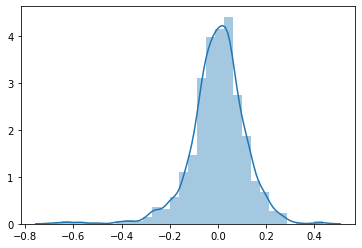

In [ ]:
#Residual error plot
e1 = y_train-(y_ridge_train.reshape(-1,1))
sns.distplot(e1,bins=30)
plt.show()

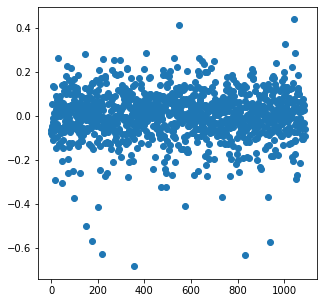

In [ ]:
#checking for the randomness in the residual error
plt.figure(figsize=(5,5))
z1 = np.arange(0,len(y_train))
plt.scatter(z1,e1)
plt.show()

In [ ]:
#Transforming the test set; using the same scaling that was used to train the Model
X_test = test.drop('SalePrice',axis=1)
y_test = test[['SalePrice']]

X_test[ob_vals] = en1.transform(X_test[ob_vals])
X_test[cols] = scaler.transform(X_test[cols])
X_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,TotalArea,TotalPorchArea,TotalBathrooms,MonthSold,HouseAge,RemodelAge
635,-1.343188,-1.996483,-0.461489,0.170038,0.060718,-0.812572,-0.757816,-3.248176,0.030317,-0.403134,-0.165672,-0.607143,-2.457876,0.068101,-3.498026,2.032374,-0.076506,-0.844779,2.093074,-0.078749,1.017126,1.047129,-0.686686,-0.574381,-2.467857,-0.246176,-0.785948,-0.558569,-1.684655,-0.488515,-1.121188,0.274047,0.120767,0.880504,0.258072,-3.291953,6.335897,4.377975,-2.293210,4.587421,-0.239989,-0.953690,-1.007697,-1.920520,-1.731766,-2.401705,-4.028219,-4.055169,-3.572937,-0.067337,-0.065493,0.436814,0.184662,-0.079137,1.788855,-0.260293,-1.055784,2.926088,-0.461172,-0.278249,0.525056,1.912308,-0.517728
535,-1.343188,0.391105,0.033256,-0.542313,0.060718,0.210526,-0.757816,-0.019388,0.030317,-0.403134,-0.165672,-0.922708,0.237673,0.068101,-3.498026,1.272661,-0.813805,-0.844779,-0.479425,-0.078749,-1.114316,-1.113159,-0.686686,-0.574381,-0.709024,-0.246176,-0.785948,0.582672,0.113962,2.509550,1.469655,0.274047,0.120767,-1.208534,0.258072,0.303771,0.157717,-0.228416,-0.780608,-0.946279,-0.239989,-0.953690,-1.007697,-1.920520,-1.731766,-2.401705,-4.028219,-4.055169,-3.572937,-0.067337,-0.065493,0.436814,0.184662,-0.079137,-0.907860,-0.260293,-0.223353,-0.125544,0.320938,-0.278249,2.099658,2.079718,-0.274834
1096,-0.286507,-2.068730,-0.461489,-0.563888,0.060718,0.210526,-0.757816,-0.019388,0.030317,-0.403134,-0.165672,-1.351809,0.237673,0.068101,0.336089,1.272661,-0.076506,-0.844779,-0.479425,-0.078749,-1.022571,-1.044575,-0.686686,-0.574381,-0.709024,-0.246176,1.095165,-0.558569,0.113962,-0.488515,-0.220389,0.274047,0.120767,-1.208534,0.258072,0.303771,0.157717,-0.228416,0.731994,0.283432,-0.239989,-0.953690,-1.007697,-1.920520,-1.731766,-2.401705,-4.028219,-4.055169,0.296504,-0.067337,-0.065493,0.436814,0.184662,-0.079137,1.788855,-0.260293,-0.223353,-0.672546,0.435393,-0.918868,0.525056,1.912308,-1.052096
563,-0.888874,0.391105,-0.164642,2.160088,0.060718,0.210526,-0.757816,-0.019388,0.030317,-0.403134,-0.165672,-0.922708,0.237673,0.068101,0.336089,-1.461337,-0.076506,-0.844779,-0.479425,-0.078749,-1.022571,-1.044575,-0.686686,-0.574381,-0.709024,-0.246176,-1.218906,0.582672,0.113962,0.399077,-0.220389,0.274047,0.120767,0.880504,0.258072,0.303771,1.393353,-0.228416,-0.780608,0.898288,-0.239989,0.610419,1.188166,-1.216961,1.396361,0.312832,0.258488,0.264439,-3.572937,-0.067337,-0.065493,0.436814,0.184662,-0.079137,-0.907860,-0.260293,-0.223353,0.354531,0.441751,-0.278249,0.798464,1.811863,1.716899
37,0.085802,0.391105,0.231153,-0.262199,0.060718,0.210526,-0.757816,-0.019388,0.030317,-0.403134,-0.165672,-0.607539,0.237673,0.068101,0.336089,-0.245206,-0.813805,-0.971382,2.093074,-0.078749,-1.022571,-1.044575,0.620787,3.118302,-0.709024,-0.246176,-0.785948,-0.558569,0.113962,-0.488515,-1.001866,0.274047,0.120767,-0.164015,0.258072,0.303771,0.157717,-0.228416,-0.780608,-0.946279,-0.239989,0.610419,0.639200,0.517104,1.396361,0.312832,0.258488,0.264439,0.296504,-0.067337,-0.065493,0.436814,0.184662,-0.079137,-0.345159,-0.260293,-0.223353,0.041775,-1.160619,-0.918868,-0.036176,0.639998,-0.177676


In [ ]:
#transforming the target variable
y_test = np.log(y_test)

In [ ]:
#making a list of the top columns selected by RFE and selecting only those from the test set
top_cols = list(X_train.columns)
X_test = X_test[top_cols]
X_test.shape

(364, 50)

In [ ]:
#Making predictions on the test data
y_ridge_pr = model_ridge.predict(X_test)

In [ ]:
#Calculating the Train and Test r2 score
print('Train r2 score:',r2_score(y_train,y_ridge_train))
print('Test r2 score:',r2_score(y_test,y_ridge_pr))

Train r2 score: 0.9176886538102409
Test r2 score: 0.8946322398213229


In [ ]:
print("Mean squared error:",mean_squared_error(y_test,y_ridge_pr))
print("Root Mean squared error:",math.sqrt(mean_squared_error(y_test,y_ridge_pr)))

Mean squared error: 0.0173115349239516
Root Mean squared error: 0.13157330627430322


In [ ]:
#calculating the adjusted r2 score
r2_ridge = r2_score(y_train,y_ridge_train)
adj_r2_ridge = (1 - (1 - r2_ridge) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print('Adjusted R2 score:',adj_r2_ridge)

Adjusted R2 score: 0.9137237527413701


In [ ]:
print('Difference in Train and Test score:', r2_score(y_train,y_ridge_train)-r2_score(y_test,y_ridge_pr) )

Difference in Train and Test score: 0.023056413988918


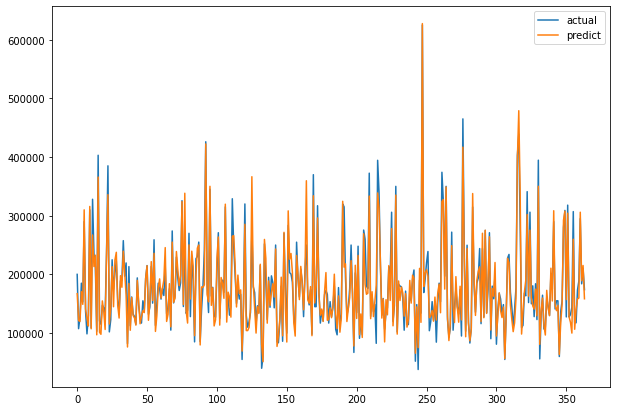

In [ ]:
#performing a inverse log transformation on the target variable

y_train_inv = np.exp(y_train)
y_ridge_train_inv = np.exp(y_ridge_train)
y_test_inv = np.exp(y_test)
y_ridge_pr_inv = np.exp(y_ridge_pr)

#plotting actual and predicted values of test set
plt.figure(figsize=(10,7))
z = np.arange(0,len(y_test_inv))
plt.plot(z,y_test_inv)
plt.plot(z,y_ridge_pr_inv)
plt.legend(['actual','predict'])
plt.show()

In [ ]:
#intercept calculated from Ridge Regression
model_ridge.intercept_

array([12.02544819])

In [ ]:
#coeffcients calculated from Ridge Regression
model_ridge.coef_

array([[ 0.02203503,  0.02541358,  0.00677867,  0.01551028,  0.00570562,
         0.00259291,  0.00393126,  0.0058854 ,  0.01211018,  0.01299302,
         0.03493217,  0.01922628, -0.01380606,  0.07342667,  0.00322438,
         0.00394823,  0.02382077, -0.02009778,  0.00416935,  0.00555747,
         0.0080982 ,  0.01054186,  0.00654114, -0.0031789 , -0.00408875,
         0.01528335, -0.00324615,  0.01393831,  0.02129317, -0.01091325,
         0.01713719,  0.02451002, -0.02933677,  0.02010301,  0.02373108,
         0.03050401, -0.01567969,  0.00617903,  0.01834495, -0.01210384,
        -0.002815  , -0.00367036, -0.01101026,  0.03260907,  0.11963643,
         0.01538762,  0.0395271 , -0.00467713,  0.01772098, -0.03112167]])

Lasso Regression

In [ ]:
#Building a GridSerach model and finding the optimum alpha value

#Defining the KFolds
folds = KFold(n_splits =5, shuffle = True, random_state = 100)

#defining range of alphas
params = {'alpha': [0.01,0.1,0.5,1.0,5.0,10.0]}

# GridSearch and lasso model
model_l1 = Lasso()
model_cv = GridSearchCV(estimator = model_l1, param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds,
                        return_train_score=True, verbose = 1,n_jobs=-1,refit=False)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
#viewing the results in a dataframe
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008222,0.000825,0.002588,0.000301,0.01,{'alpha': 0.01},-0.086619,-0.083772,-0.093515,-0.091282,-0.084743,-0.087986,0.003784,1,-0.084937,-0.086355,-0.084163,-0.083784,-0.085100,-0.084868,0.000888
1,0.007689,0.002359,0.002445,0.000204,0.1,{'alpha': 0.1},-0.151179,-0.144259,-0.152448,-0.134563,-0.130566,-0.142603,0.008749,2,-0.142935,-0.141638,-0.139939,-0.140271,-0.140576,-0.141072,0.001092
2,0.006858,0.002783,0.002308,0.000083,0.5,{'alpha': 0.5},-0.341537,-0.307819,-0.313711,-0.290760,-0.292718,-0.309309,0.018328,3,-0.301447,-0.309559,-0.308209,-0.313607,-0.313548,-0.309274,0.004462
3,0.008880,0.004522,0.002903,0.001241,1,{'alpha': 1.0},-0.341537,-0.307819,-0.313711,-0.290760,-0.292718,-0.309309,0.018328,3,-0.301447,-0.309559,-0.308209,-0.313607,-0.313548,-0.309274,0.004462
4,0.005651,0.000474,0.003414,0.001737,5,{'alpha': 5.0},-0.341537,-0.307819,-0.313711,-0.290760,-0.292718,-0.309309,0.018328,3,-0.301447,-0.309559,-0.308209,-0.313607,-0.313548,-0.309274,0.004462
5,0.005627,0.000748,0.002214,0.000129,10,{'alpha': 10.0},-0.341537,-0.307819,-0.313711,-0.290760,-0.292718,-0.309309,0.018328,3,-0.301447,-0.309559,-0.308209,-0.313607,-0.313548,-0.309274,0.004462


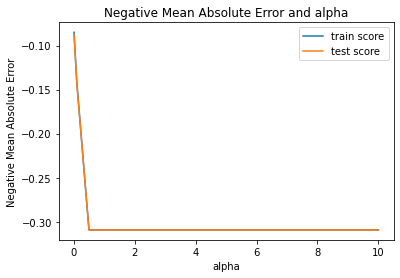

In [ ]:
# plotting the train and test mean score with the alpha values
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'])
plt.show()

In [ ]:
#Building a Lasso Model for the chosen alpha value
model_lasso = Lasso(alpha=0.001,random_state=1)
model_lasso.fit(X_train,y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
#predicting the train y values for evalution 
y_lasso_train = model_lasso.predict(X_train)

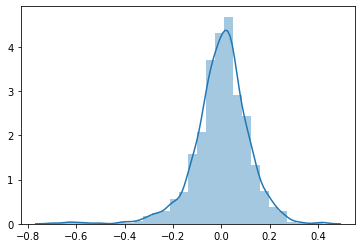

In [ ]:
#Residual error plot
e2 = y_train-(y_lasso_train.reshape(-1,1))
sns.distplot(e2,bins=30)
plt.show()

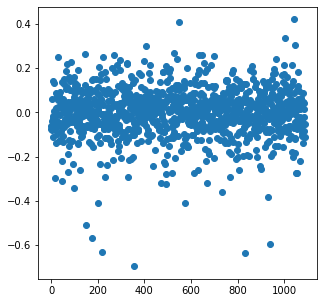

In [ ]:
#checking for the randomness in the residual error
plt.figure(figsize=(5,5))
z2 = np.arange(0,len(y_train))
plt.scatter(z2,e2)
plt.show()

In [ ]:
#predicting the values for test set
y_lasso_pr = model_lasso.predict(X_test)

In [ ]:
#Calculating the train and test r2 score
print('Train r2:',r2_score(y_train,y_lasso_train))
print('Test r2:',r2_score(y_test,y_lasso_pr))

Train r2: 0.9167656744092355
Test r2: 0.8959338791322773


In [ ]:
#Calculating the adjusted r2 score
r2_lasso = r2_score(y_train,y_lasso_train)
adj_r2_lasso = (1 - (1 - r2_lasso) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted R2 score for Lasso Model:",adj_r2_lasso)

Adjusted R2 score for Lasso Model: 0.9127563138316457


In [ ]:
print('Difference in Train and Test R2:',r2_score(y_train,y_lasso_train)-r2_score(y_test,y_lasso_pr))

Difference in Train and Test R2: 0.02083179527695822


In [ ]:
print("Mean squared error:",mean_squared_error(y_test,y_lasso_pr))
print("Root Mean squared error:",math.sqrt(mean_squared_error(y_test,y_lasso_pr)))

Mean squared error: 0.017097680379148092
Root Mean squared error: 0.13075809871341848


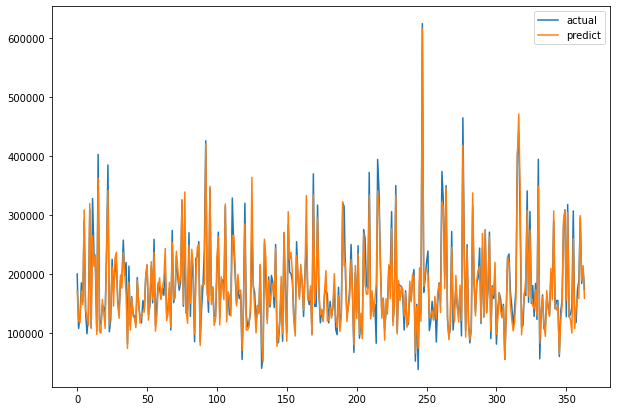

In [ ]:
#performing a inverse log transformation on the target variable

y_train_inv = np.exp(y_train)
y_lasso_train_inv = np.exp(y_lasso_train)
y_test_inv = np.exp(y_test)
y_lasso_pr_inv = np.exp(y_lasso_pr)

#plotting actual and predicted values of test set
plt.figure(figsize=(10,7))
z = np.arange(0,len(y_test_inv))
plt.plot(z,y_test_inv)
plt.plot(z,y_lasso_pr_inv)
plt.legend(['actual','predict'])
plt.show()

In [ ]:
#Brining in the faetures and their respective coeffs into a dataframe
lasso_coeff_df = pd.DataFrame({"Feature":X_test.columns,"Coefficients":np.transpose(model_lasso.coef_)})
lasso_coeff_df['Coefficients'] = round(lasso_coeff_df['Coefficients'],5)

#sorting the dataframe based on the absolute value
lasso_coeff_df =  lasso_coeff_df.reindex(lasso_coeff_df.Coefficients.abs().sort_values(ascending=False).index)

#top 10 features are:
lasso_coeff_df.head(10)

,Feature,Coefficients
44,TotalArea,0.12210
13,OverallQual,0.07352
46,TotalBathrooms,0.03749
10,Neighborhood,0.03452
49,RemodelAge,-0.03009
32,Functional,-0.02843
1,MSZoning,0.02546
31,TotRmsAbvGrd,0.02360
34,GarageCars,0.02208
43,SaleCondition,0.02146


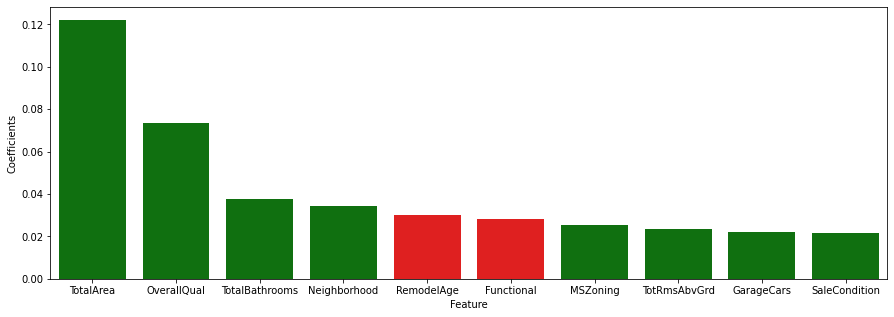

In [ ]:
#plotting the top10 features
#Green indicates a positive co-eff while red indicates a negative co-eff
plt.figure(figsize=(15,5))
sns.barplot(lasso_coeff_df.Feature[:10],np.abs(lasso_coeff_df.Coefficients),palette=['red' if coeff < 0 else 'green' for coeff in list(lasso_coeff_df.Coefficients.values)])
plt.show()

The top5 features identified as per the model are:


1.   Total Area
1.   Overall Qual
2.   TotalBathrooms
2.   Neighborhood
5. RemodelAge



##Assignment Answers

###Question1: When the alpha values are doubled


---

Ridge Regression

In [ ]:
#Building a Ridge Regression model for the choosen alpha value
model_ridge_1 = Ridge(alpha=10,random_state=1)
model_ridge_1.fit(X_train,y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=1, solver='auto', tol=0.001)

In [ ]:
#predicting the train values for evaluation
y_ridge_train_1 = model_ridge_1.predict(X_train)

In [ ]:
#Making predictions on the test data
y_ridge_pr_1 = model_ridge_1.predict(X_test)

In [ ]:
#Calculating the Train and Test r2 score
print('Train r2 score:',r2_score(y_train,y_ridge_train_1))
print('Test r2 score:',r2_score(y_test,y_ridge_pr_1))

Train r2 score: 0.917646414758485
Test r2 score: 0.8948360261603228


In [ ]:
print("Mean squared error:",mean_squared_error(y_test,y_ridge_pr_1))
print("Root Mean squared error:",math.sqrt(mean_squared_error(y_test,y_ridge_pr_1)))

Mean squared error: 0.017278053579006632
Root Mean squared error: 0.1314460101296598


In [ ]:
#calculating the adjusted r2 score
r2_ridge_1 = r2_score(y_train,y_ridge_train_1)
adj_r2_ridge_1 = (1 - (1 - r2_ridge_1) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print('Adjusted R2 score:',adj_r2_ridge_1)

Adjusted R2 score: 0.9136794790532097


In [ ]:
print('Difference in Train and Test score:', r2_score(y_train,y_ridge_train_1)-r2_score(y_test,y_ridge_pr_1) )

Difference in Train and Test score: 0.0228103885981622


Lasso Regression

In [ ]:
#Building a Lasso Model for the double of the chosen alpha value
model_lasso_1 = Lasso(alpha=0.002,random_state=1)
model_lasso_1.fit(X_train,y_train)

Lasso(alpha=0.002, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
#predicting the train y values for evalution 
y_lasso_train_1 = model_lasso_1.predict(X_train)

In [ ]:
#predicting the values for test set
y_lasso_pr_1 = model_lasso_1.predict(X_test)

In [ ]:
#Calculating the train and test r2 score
print('Train r2:',r2_score(y_train,y_lasso_train_1))
print('Test r2:',r2_score(y_test,y_lasso_pr_1))

Train r2: 0.9156110798833168
Test r2: 0.8959648228111947


In [ ]:
#Calculating the adjusted r2 score
r2_lasso_1 = r2_score(y_train,y_lasso_train_1)
adj_r2_lasso_1 = (1 - (1 - r2_lasso_1) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted R2 score for Lasso Model:",adj_r2_lasso_1)

Adjusted R2 score for Lasso Model: 0.9115461029990835


In [ ]:
print("Mean squared error:",mean_squared_error(y_test,y_lasso_pr_1))
print("Root Mean squared error:",math.sqrt(mean_squared_error(y_test,y_lasso_pr_1)))

Mean squared error: 0.017092596446668683
Root Mean squared error: 0.13073865704782456


In [ ]:
print('Difference in Train and Test R2:',r2_score(y_train,y_lasso_train_1)-r2_score(y_test,y_lasso_pr_1))

Difference in Train and Test R2: 0.019646257072122086


In [ ]:
#Brining in the faetures and their respective coeffs into a dataframe
lasso_coeff_df_2 = pd.DataFrame({"Feature":X_test.columns,"Coefficients":np.transpose(model_lasso_1.coef_)})
lasso_coeff_df_2['Coefficients'] = round(lasso_coeff_df_2['Coefficients'],5)

#sorting the dataframe based on the absolute value
lasso_coeff_df_2 =  lasso_coeff_df_2.reindex(lasso_coeff_df_2.Coefficients.abs().sort_values(ascending=False).index)

#top 10 features are:
lasso_coeff_df_2.head()

,Feature,Coefficients
44,TotalArea,0.12346
13,OverallQual,0.07346
46,TotalBathrooms,0.03594
10,Neighborhood,0.03405
49,RemodelAge,-0.02855


###Question3 - Building a Lasso model in the absense of its top 5 contributers

In [ ]:
#listing the top 5 features with the help of the dataframe created earlier
top_5_features = list(lasso_coeff_df.Feature[:5])
new_X_train = X_train.drop(labels=top_5_features,axis=1)
print("Shape of the new train set:",new_X_train.shape)

Shape of the new train set: (1089, 45)


In [ ]:
#Building a Lasso Model for the chosen alpha value
model_lasso_2 = Lasso(alpha=0.001,random_state=1)
model_lasso_2.fit(new_X_train,y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
#predicting the train y values for evalution 
y_lasso_train_1 = model_lasso_2.predict(new_X_train)

In [ ]:
#deleting the entries from the test set as well
new_X_test = X_test.drop(labels=top_5_features,axis=1)
print("Shape of the new Train Set:",new_X_test.shape)

Shape of the new Train Set: (364, 45)


In [ ]:
#predicting the values for test set
y_lasso_pr_1 = model_lasso_2.predict(new_X_test)

In [ ]:
#Calculating the train and test r2 score
print('Train r2:',r2_score(y_train,y_lasso_train_1))
print('Test r2:',r2_score(y_test,y_lasso_pr_1))

Train r2: 0.8627078842907039
Test r2: 0.8296329965342618


In [ ]:
#Calculating the adjusted r2 score
r2_lasso_1 = r2_score(y_train,y_lasso_train_1)
adj_r2_lasso_1 = (1 - (1 - r2_lasso_1) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adjusted R2 score for Lasso Model:",adj_r2_lasso_1)

Adjusted R2 score for Lasso Model: 0.8560945839193506


In [ ]:
print("Mean squared error:",mean_squared_error(y_test,y_lasso_pr_1))
print("Root Mean squared error:",math.sqrt(mean_squared_error(y_test,y_lasso_pr_1)))

Mean squared error: 0.02799067120136954
Root Mean squared error: 0.1673041278670958


In [ ]:
print('Difference in Train and Test R2:',r2_score(y_train,y_lasso_train_1)-r2_score(y_test,y_lasso_pr_1))

Difference in Train and Test R2: 0.03307488775644207


In [ ]:
#Brining in the faetures and their respective coeffs into a dataframe
lasso_coeff_df1 = pd.DataFrame({"Feature":new_X_test.columns,"Coefficients":np.transpose(model_lasso_2.coef_)})
lasso_coeff_df1['Coefficients'] = round(lasso_coeff_df1['Coefficients'],5)

#sorting the dataframe based on the absolute value
lasso_coeff_df1 =  lasso_coeff_df1.reindex(lasso_coeff_df1.Coefficients.abs().sort_values(ascending=False).index)

#top 10 features are:
lasso_coeff_df1.head(10)

,Feature,Coefficients
29,TotRmsAbvGrd,0.09462
32,GarageCars,0.05585
28,KitchenQual,0.05378
31,Fireplaces,0.04841
18,ExterQual,0.04662
1,MSZoning,0.04468
21,BsmtQual,0.04369
42,TotalPorchArea,0.03433
23,BsmtExposure,0.02818
14,Exterior1st,0.02720


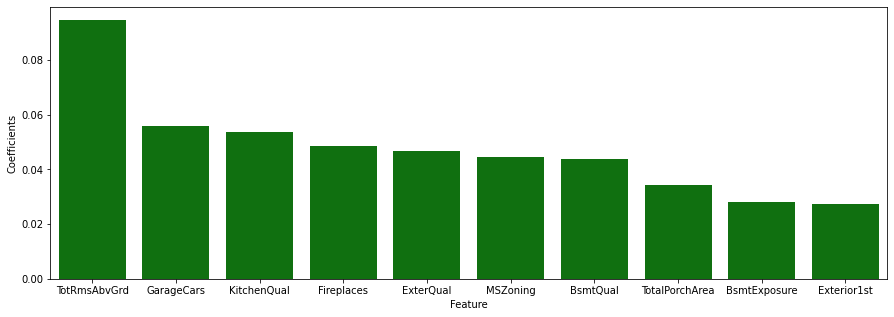

In [ ]:
#plotting the top10 features
#Green indicates a positive co-eff while red indicates a negative co-eff
plt.figure(figsize=(15,5))
sns.barplot(lasso_coeff_df1.Feature[:10],np.abs(lasso_coeff_df1.Coefficients),palette=['red' if coeff < 0 else 'green' for coeff in list(lasso_coeff_df1.Coefficients.values)])
plt.show()

In [ ]:
print("Top 5 attributes from the new model are:\n", lasso_coeff_df1.Feature.values[:5])

Top 5 attributes from the new model are:
 ['TotRmsAbvGrd' 'GarageCars' 'KitchenQual' 'Fireplaces' 'ExterQual']
